# Lab | Sequence Modeling with LSTM

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=16000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [2]:
num_sentences = 0

with open('training.1600000.processed.noemoticon.csv', 'r', encoding='latin-1') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        # YOUR CODE HERE
        list_item.append(row[5])  # Text is in row[5]
        
        # Label is '0' if the sentiment is negative, otherwise '1'
        label = 0 if row[0] == '0' else 1
        
        list_item.append(label)
        
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [3]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [4]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])  # Extracting the text (sentence)
    labels.append(corpus[x][1])     # Extracting the label (0 or 1)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)   # Fit tokenizer on the list of sentences to generate vocabulary

word_index = tokenizer.word_index
vocab_size = len(word_index)        # Determine the vocabulary size

sequences = tokenizer.texts_to_sequences(sentences)    # Convert sentences to sequences of integers
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) # Pad sequences to ensure uniform length for model input

split = int(test_portion * training_size)

test_sequences = padded[:split]    # First 'split' elements go to the test set
training_sequences = padded[split:] # Remaining elements go to the training set
test_labels = labels[:split]    # First 'split' labels go to the test set
training_labels = labels[split:] # Remaining labels go to the training set

In [5]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

26550
1


In [6]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [7]:
print(len(embeddings_matrix))
# Expected Output
# 138859

26551


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-06-13 18:15:54.317953: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-13 18:15:54.317981: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-13 18:15:54.317989: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-13 18:15:54.318013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 18:15:54.318027: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,655,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,655,100 (10.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,655,100 (10.13 MB)

In [9]:
# Train the model
num_epochs = 50
history = model.fit(
    training_sequences, np.array(training_labels),
    epochs=num_epochs, 
    validation_data=(test_sequences, np.array(test_labels)), 
    verbose=2  # Increase verbosity to see training progress
)

print("Training Complete")

Epoch 1/50


2024-06-13 18:15:55.199873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


450/450 - 46s - 102ms/step - accuracy: 0.6703 - loss: 0.6014 - val_accuracy: 0.6881 - val_loss: 0.5774
Epoch 2/50
450/450 - 42s - 94ms/step - accuracy: 0.7249 - loss: 0.5421 - val_accuracy: 0.6956 - val_loss: 0.5853
Epoch 3/50
450/450 - 43s - 95ms/step - accuracy: 0.7374 - loss: 0.5202 - val_accuracy: 0.7044 - val_loss: 0.5451
Epoch 4/50
450/450 - 43s - 95ms/step - accuracy: 0.7542 - loss: 0.4972 - val_accuracy: 0.7200 - val_loss: 0.5301
Epoch 5/50
450/450 - 43s - 95ms/step - accuracy: 0.7733 - loss: 0.4729 - val_accuracy: 0.7175 - val_loss: 0.5505
Epoch 6/50
450/450 - 43s - 95ms/step - accuracy: 0.7882 - loss: 0.4463 - val_accuracy: 0.7294 - val_loss: 0.5483
Epoch 7/50
450/450 - 43s - 95ms/step - accuracy: 0.8104 - loss: 0.4062 - val_accuracy: 0.7169 - val_loss: 0.5626
Epoch 8/50
450/450 - 42s - 94ms/step - accuracy: 0.8294 - loss: 0.3697 - val_accuracy: 0.7188 - val_loss: 0.6308
Epoch 9/50
450/450 - 43s - 96ms/step - accuracy: 0.8559 - loss: 0.3220 - val_accuracy: 0.7006 - val_loss: 

<Figure size 640x480 with 0 Axes>

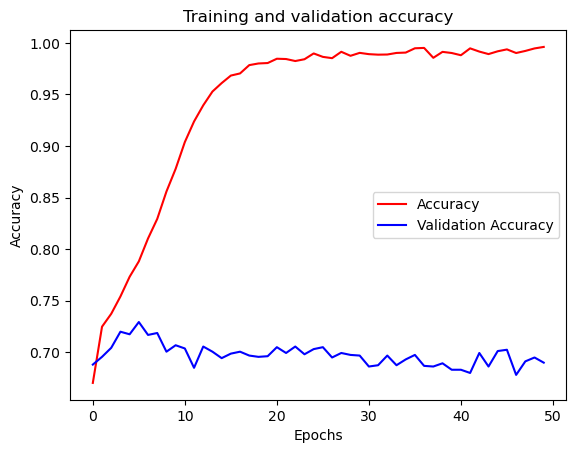

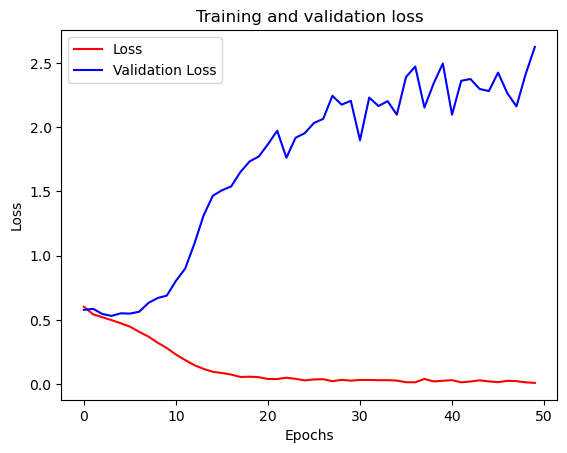

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!